# Lane Segmentation Demo

In [1]:
import os
import cv2
from matplotlib import pyplot as plt
from matplotlib import patches as pat
from matplotlib import colors as mpl_colors
import numpy as np

## Defining Input File

In [2]:
media = os.listdir("./test_media")
media

['Video11.mp4', 'videoplayback.mp4']

In [3]:
SOURCE = os.path.join(os.getcwd(), "test_media", media[0])
SOURCE

'/Users/adrielamoguis/THESIS/Trajectory Tracking/Road-Lane-Detection-With-YOLOv7-SORT/test_media/Video11.mp4'

## Running the YOLOv7 + SORT Tracker

In [9]:
!python3 yolov7_object_tracking/detect_and_track.py \
    --source "$SOURCE" \
    --weights yolov7.pt \
    --save-bbox --save-txt \
    --classes 1 2 3 5 7 \
    --img 640 \
    --view-img

## Processing the Tracked Trajectories

In [4]:
ROOT = os.getcwd()

In [5]:
tracking_runs = sorted(os.listdir('./runs/detect'))
tracking_runs

['.DS_Store',
 'object_tracking',
 'object_tracking2',
 'object_tracking3',
 'object_tracking4']

In [6]:
SOURCE_RUN_DIR = os.path.join(os.getcwd(), "runs", "detect", tracking_runs[4])
SOURCE_RUN_DIR

'/Users/adrielamoguis/THESIS/Trajectory Tracking/Road-Lane-Detection-With-YOLOv7-SORT/runs/detect/object_tracking4'

In [7]:
dir_contents = os.listdir(SOURCE_RUN_DIR)
dir_contents.sort()
dir_contents

['.DS_Store', 'labels', 'videoplayback.mp4']

In [8]:
LABELS_DIR = os.path.join(SOURCE_RUN_DIR, 'labels')
SOURCE_VIDEO = os.path.join(SOURCE_RUN_DIR, dir_contents[2])
SOURCE_VIDEO

'/Users/adrielamoguis/THESIS/Trajectory Tracking/Road-Lane-Detection-With-YOLOv7-SORT/runs/detect/object_tracking4/videoplayback.mp4'

## Preliminary Trajectory Inspection

(360, 640, 3)

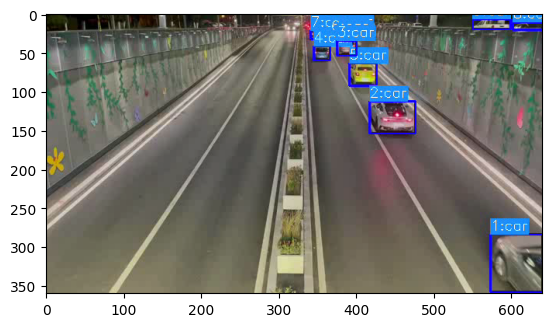

In [9]:
# Grab video frame as canvas
vidcap = cv2.VideoCapture(SOURCE_VIDEO)
success, img = vidcap.read()

assert success, "Video could not be read."

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
img.shape

### Cropping

In [10]:
crop_x_min = 0
crop_x_max = img.shape[1]
crop_y_min = 25
crop_y_max = img.shape[0]

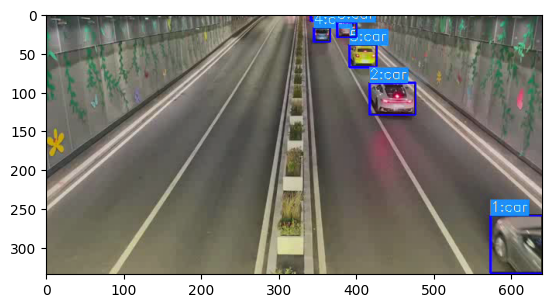

In [11]:
img = img[crop_y_min:crop_y_max, crop_x_min:crop_x_max]
plt.imshow(img)

In [25]:
# Read all labels
os.chdir(LABELS_DIR)

frames_trk_dets = os.listdir()
frames_trk_dets.sort(key=lambda e: e.split("_")[1].split(".")[0])

frame_dets = []
for frame in frames_trk_dets:
    frame_preds = ""
    with open(frame, "r") as f:
        dets = f.readlines()
    
    # VehicleID, Vehicle Class, Centroid_X, Centroid_Y, Bbox_W, Bbox_H
    ds = []
    for d in dets:
        d = d[:-1]
        d = d.split(" ")
        ds.append([int(d[0]), int(d[1]), float(d[2]), float(d[3]), float(d[4]), float(d[5])])
    frame_dets.append(ds)

In [26]:
# Define the first paramter, max vehicle ID
MAX_VEHICLE_ID = 1584

### Visualize

In [27]:
def is_id_in_frame(vehicle_id, frame) -> bool:
    for dets in frame:
        if dets[0] == vehicle_id:
            return True
    return False

vehicle_lines = []
for vehicle_id in range(MAX_VEHICLE_ID):
    # Grab all of id's centroids
    # Grab frames where vehicle_id is present
    present_frames = list(filter(lambda x: is_id_in_frame(vehicle_id, x), frame_dets))
    
    # For all the frames where the vehicle is present, generate a list of points
    centroids_x = []
    centroids_y = []
    bounding_boxes = []
    for pf in present_frames:
        for dets in pf:
            if dets[0] == vehicle_id:
                # Check if within constraints
                x_denormalized = dets[2] * img.shape[1]
                y_denormalized = dets[3] * img.shape[0]
                if crop_x_min < x_denormalized < crop_x_max and crop_y_min < y_denormalized < crop_y_max:
                    centroids_x.append(x_denormalized)
                    centroids_y.append(y_denormalized)
                    bounding_boxes.append([dets[4] * img.shape[1], dets[5] * img.shape[0]])
    vehicle_lines.append({
        "v_id": vehicle_id,
        "x_coords": centroids_x,
        "y_coords": centroids_y,
        "bbox": bounding_boxes
    })

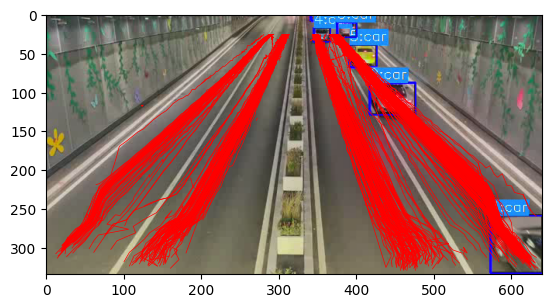

In [28]:
for line in vehicle_lines:
    x = line["x_coords"]
    y = line["y_coords"]
    plt.plot(x, y, color="red", linewidth=0.5)

plt.imshow(img)
plt.show()

## Representing the Trajectories as Vectors

[v_id, x, y, w, h]

In [29]:
# Transform Centroid Points into a Numpy Matrix of (x, y)
centroids_arr = []
for line in vehicle_lines:
    x = line["x_coords"]
    y = line["y_coords"]
    for i in range(len(x)):
        centroids_arr.append([line["v_id"], x[i],y[i], line["bbox"][i][0], line["bbox"][i][1]])
centroids = np.array(centroids_arr)
print(centroids.shape)
centroids

(63988, 5)


array([[   0.      ,  606.      ,  298.708445,  119.11104 ,   38.734375],
       [   0.      ,  576.      ,  245.666555,  225.77792 ,   55.484375],
       [   0.      ,  410.      ,   71.652815,   62.22208 ,   13.08577 ],
       ...,
       [1583.      ,  457.00032 ,  117.25    ,  115.55584 ,   24.60173 ],
       [1583.      ,  457.00032 ,  117.25    ,  115.55584 ,   24.60173 ],
       [1583.      ,  457.00032 ,  117.25    ,  115.55584 ,   24.60173 ]])

## Defining Parameter 1: The Operational Area

In [30]:
operational_x_min = 0
operational_x_max = 640
operational_y_min = 150
operational_y_max = 250

In [31]:
operational_centroids = []
for centroid in centroids:
    if operational_x_min < centroid[1] < operational_x_max and operational_y_min < centroid[2] < operational_y_max:
        operational_centroids.append(centroid)
operational_centroids = np.array(operational_centroids)

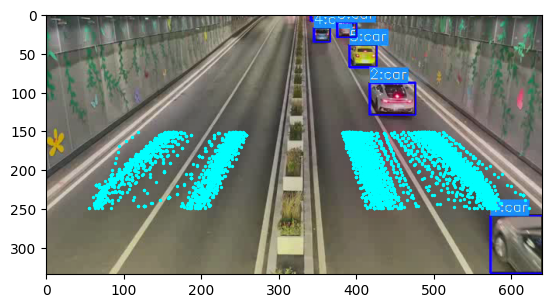

In [33]:
plt.scatter(operational_centroids[:, 1], operational_centroids[:, 2], color='cyan', s=2)
plt.imshow(img)

## Clustering with Different Clustering Algorithms

In [34]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS

In [35]:
clustering_outputs = {}

### KMeans Clustering

In [36]:
EXPECTED_NUMBER_OF_LANES = 4

In [37]:
kmeans_model = KMeans(n_clusters=EXPECTED_NUMBER_OF_LANES)
kmeans_clustered = kmeans_model.fit(operational_centroids[:, [1,2]])
kmeans_cluster_centers = kmeans_clustered.cluster_centers_
clustering_outputs['kmeans'] = kmeans_model
kmeans_cluster_centers

array([[221.15588042, 190.56379508],
       [526.09137599, 191.00694952],
       [415.56758408, 189.72891381],
       [118.69537478, 192.41007889]])

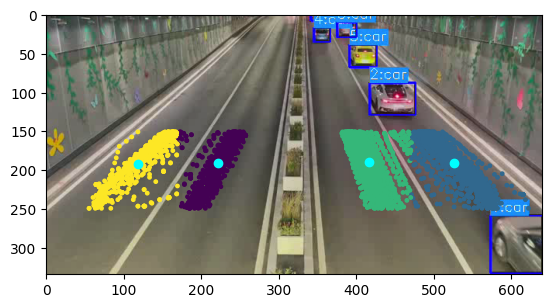

In [38]:
plt.imshow(img)
plt.scatter(operational_centroids[:, 1], operational_centroids[:, 2], c=kmeans_clustered.labels_, s=6)
plt.scatter(kmeans_cluster_centers[:,0], kmeans_cluster_centers[:,1], color="cyan")
plt.show()

### DBSCAN Clustering

In [39]:
CORE_SAMPLE_DISTANCE_EPS = 16
MIN_SAMPLES = 128

In [40]:
dbscan_model = DBSCAN(eps=CORE_SAMPLE_DISTANCE_EPS, min_samples=MIN_SAMPLES)
dbscan_clustered = dbscan_model.fit(operational_centroids[:, [1,2]])
clustering_outputs['dbscan'] = dbscan_model

In [41]:
np.max(dbscan_clustered.labels_), np.min(dbscan_clustered.labels_)

(3, -1)

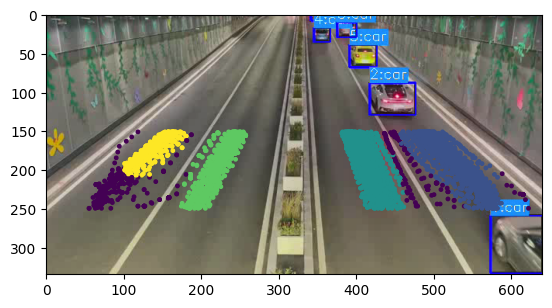

In [42]:
plt.imshow(img)
plt.scatter(operational_centroids[:, 1], operational_centroids[:, 2], c=dbscan_clustered.labels_, s=6)
plt.show()

### OPTICS Clustering

In [61]:
MAX_CORE_SAMPLE_DISTANCE_EPS = 24
MIN_SAMPLES = 256

In [62]:
optics_model = OPTICS(max_eps=MAX_CORE_SAMPLE_DISTANCE_EPS, min_samples=MIN_SAMPLES)
optics_clustered = optics_model.fit(operational_centroids[:, [1,2]])
clustering_outputs['optics'] = optics_model

In [63]:
np.max(optics_clustered.labels_), np.min(optics_clustered.labels_)

(3, -1)

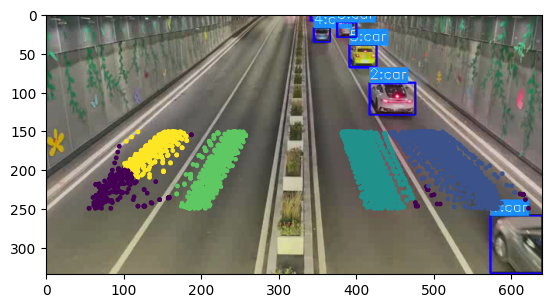

In [64]:
plt.imshow(img)
plt.scatter(operational_centroids[:, 1], operational_centroids[:, 2], c=optics_clustered.labels_, s=6)
plt.show()

## Projection of Lane Assignments / Lane Clusters

In [88]:
CLUSTER_OUTPUT_TO_USE = 'optics'

In [89]:
cluster_assignments = np.empty((operational_centroids.shape[0], 1))
for i in range(operational_centroids.shape[0]):
    cluster_assignments[i] = clustering_outputs[CLUSTER_OUTPUT_TO_USE].labels_[i]
    
clustered_operational_centroids = np.append(operational_centroids, cluster_assignments, axis=1)

In [90]:
# Separate into different clusters
clusters = []
for i in range(int(np.max(clustered_operational_centroids[:,5]) + 1)):
    c = []
    for j in range(clustered_operational_centroids.shape[0]):
        if int(clustered_operational_centroids[j,5]) == i:
            c.append(clustered_operational_centroids[j])
    clusters.append(np.array(c))
            
for cluster in clusters:
    print(len(cluster))

2820
1951
1232
518


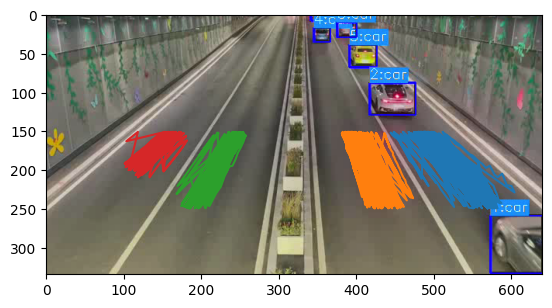

In [91]:
# Visualize
for i in range(len(clusters)):
    cluster_centroids = clusters[i]
    plt.plot(cluster_centroids[:,1], cluster_centroids[:,2])

plt.imshow(img)
plt.show()

In [97]:
def find_cluster(v_id, clusters):
    # Linear searching
    for c in range(len(clusters)):
        for i in range(clusters[c].shape[0]):
            if clusters[c][i,0] == v_id:
                return c
    return -1

all_centroid_assignments = np.empty((centroids.shape[0], 1))
for i in range(centroids.shape[0]):
    all_centroid_assignments[i] = find_cluster(int(centroids[i,0]), clusters)
all_centroids = np.append(centroids, all_centroid_assignments, axis=1)
all_centroids

array([[ 0.00000000e+00,  6.06000000e+02,  2.98708445e+02,
         1.19111040e+02,  3.87343750e+01,  0.00000000e+00],
       [ 0.00000000e+00,  5.76000000e+02,  2.45666555e+02,
         2.25777920e+02,  5.54843750e+01,  0.00000000e+00],
       [ 0.00000000e+00,  4.10000000e+02,  7.16528150e+01,
         6.22220800e+01,  1.30857700e+01,  0.00000000e+00],
       ...,
       [ 1.58300000e+03,  4.57000320e+02,  1.17250000e+02,
         1.15555840e+02,  2.46017300e+01, -1.00000000e+00],
       [ 1.58300000e+03,  4.57000320e+02,  1.17250000e+02,
         1.15555840e+02,  2.46017300e+01, -1.00000000e+00],
       [ 1.58300000e+03,  4.57000320e+02,  1.17250000e+02,
         1.15555840e+02,  2.46017300e+01, -1.00000000e+00]])

In [98]:
projected_clusters = []
for i in range(int(np.max(all_centroids[:,5]) + 1)):
    c = []
    for j in range(all_centroids.shape[0]):
        if all_centroids[j,5] == i:
            c.append(all_centroids[j])
    projected_clusters.append(np.array(c))
            
for cluster in projected_clusters:
    print(len(cluster))

20523
14943
7359
5365


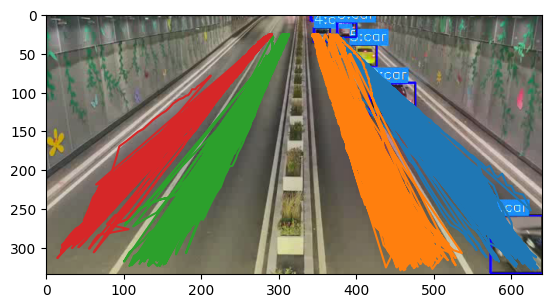

In [99]:
# Visualize ALL projected trajectories

for i in range(len(projected_clusters)):
    cluster_centroids = projected_clusters[i]
    plt.plot(cluster_centroids[:,1], cluster_centroids[:,2])

plt.imshow(img)
plt.show()

## Generating Lane Representations

In [101]:
# Sort into lines per cluster
sorted_projected_clusters = []

for cluster in projected_clusters:
    lines = []
    for i in range(int(np.max(cluster[:,0])) + 1):
        line = cluster[cluster[:,0] == i]
        lines.append(line)
    sorted_projected_clusters.append(lines)

In [103]:
# Sort by y-value
for c in range(len(sorted_projected_clusters)):
    for l in range(len(sorted_projected_clusters[c])):
        # Sort line
        sorted_projected_clusters[c][l] = np.flip(sorted_projected_clusters[c][l][sorted_projected_clusters[c][l][:, 2].argsort()], axis=0)

In [105]:
# Aggregate all Trajectories into one trajectory per cluster
fine_aggregation_coefficient = 60
query_centroids = np.linspace(0, 1, num=fine_aggregation_coefficient)
aggregated_trajectories = []

print(aggregated_trajectories, "<----= Initialized trajectories list")

print(query_centroids, "<----= Centroid Query Points")

for c in range(len(sorted_projected_clusters)):
    cluster_agg = []
    for i in range(fine_aggregation_coefficient):
        n_points = 0
        sum_x = 0
        sum_y = 0
        sum_bbox_len = 0
        for l in range(len(sorted_projected_clusters[c])):
            if sorted_projected_clusters[c][l].shape[0] > 0:
                bbox_weights = sorted_projected_clusters[c][l][int(sorted_projected_clusters[c][l].shape[0] * query_centroids[i]) - 1, 2] / sorted_projected_clusters[c][l][0,2]
                sum_x += sorted_projected_clusters[c][l][int(sorted_projected_clusters[c][l].shape[0] * query_centroids[i]) - 1, 1]
                sum_y += sorted_projected_clusters[c][l][int(sorted_projected_clusters[c][l].shape[0] * query_centroids[i]) - 1, 2]
                sum_bbox_len += sorted_projected_clusters[c][l][int(sorted_projected_clusters[c][l].shape[0] * query_centroids[i]) - 1, 3] * bbox_weights
                n_points += 1
        cluster_agg.append([sum_x/n_points, sum_y/n_points, sum_bbox_len/n_points])
    aggregated_trajectories.append(cluster_agg)

[] <----= Initialized trajectories list
[0.         0.01694915 0.03389831 0.05084746 0.06779661 0.08474576
 0.10169492 0.11864407 0.13559322 0.15254237 0.16949153 0.18644068
 0.20338983 0.22033898 0.23728814 0.25423729 0.27118644 0.28813559
 0.30508475 0.3220339  0.33898305 0.3559322  0.37288136 0.38983051
 0.40677966 0.42372881 0.44067797 0.45762712 0.47457627 0.49152542
 0.50847458 0.52542373 0.54237288 0.55932203 0.57627119 0.59322034
 0.61016949 0.62711864 0.6440678  0.66101695 0.6779661  0.69491525
 0.71186441 0.72881356 0.74576271 0.76271186 0.77966102 0.79661017
 0.81355932 0.83050847 0.84745763 0.86440678 0.88135593 0.89830508
 0.91525424 0.93220339 0.94915254 0.96610169 0.98305085 1.        ] <----= Centroid Query Points


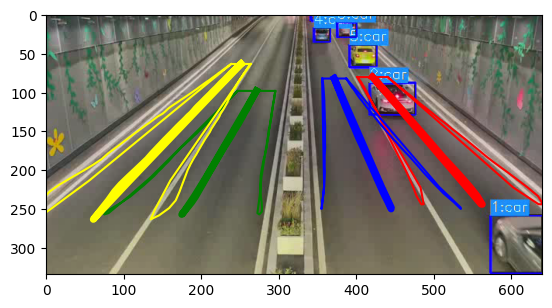

In [107]:
# Visualize Lane Tendency
color_map = ["red", "blue", "green", "yellow", "brown", "orange", "purple", "pink", "black"]

for i in range(len(aggregated_trajectories)):
    c = np.array(aggregated_trajectories[i])
    # Construct bounding points
    left_bounds = c[:,0] - (c[:,2]/2)
    right_bounds = c[:,0] + (c[:,2]/2)
    left_bound_points = np.stack([left_bounds, c[:,1]], axis=1)
    right_bound_points = np.stack([right_bounds, c[:,1]], axis=1)
    polygon_keypoints = np.concatenate([left_bound_points, right_bound_points])
    plt.plot(polygon_keypoints[:,0], polygon_keypoints[:,1], color=color_map[i], linewidth=1.5)
    plt.plot(c[:,0], c[:,1], color=color_map[i], linewidth=5)

# for traj in aggregated_trajectories:
#     for line in traj:
#         x = line["x_coords"]
#         y = line["y_coords"]
#         plt.plot(x, y, color=color_map[line["lane_cluster"]], linewidth=0.5)
    
plt.imshow(img)
plt.show()

## Drawing Lane Masks